In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
caminho = r"/content/drive/MyDrive/8ºSEMESTRE/TG/base_final.parquet"
base = pd.read_parquet(caminho)
base = base[base['var_2'] > 15]

In [ ]:
base['var_325'] = base['var_325'].astype('category')
base['var_1'] = base['var_1'].astype('category')
base['var_339'] = base['var_339'].astype('category')
base['CAT_var_275'] = base['CAT_var_275'].astype('category')
base['var_365'] = base['var_365'].astype('category')
base['var_resposta'] = base['var_resposta'].astype('category')

In [ ]:
#base["var_resposta"] = 1-base["var_resposta"]

#base["var_resposta"]= base["var_resposta"].astype('category')

In [ ]:
base["var_resposta"].value_counts()

,count
var_resposta,
0,389349
1,22120


In [ ]:
treino = base[base['split'] == "Treinamento"]
import random
np.random.seed(290)
split = np.random.choice(['Treinamento', 'Validacao'], size = len(treino), p = [0.8, 0.2])

# Adicionando a coluna 'split' na base de dados
treino['split'] = split
print(treino['split'].value_counts())

split
Treinamento    263226
Validacao       65773
Name: count, dtype: int64


<ipython-input-11-edcd998e3244>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['split'] = split


In [ ]:
treinof = treino[treino['split'] == "Treinamento"]
treinof = treinof.drop(columns = ["split"])

X_treino = treinof.drop(["var_resposta"],axis=1)
Y_treino = treinof["var_resposta"]
print(X_treino.shape)

(263226, 213)


In [ ]:
valid = treino[treino['split'] == "Validacao"]
valid = valid.drop(columns = ["split"])


X_valid = valid.drop(["var_resposta"],axis=1)
Y_valid = valid["var_resposta"]
print(X_valid.shape)

(65773, 213)


In [ ]:
teste = base[base['split'] == "Teste"]
teste = teste.drop(columns = ["split"])
X_teste = teste.drop(["var_resposta"],axis=1)
Y_teste = teste["var_resposta"]
print(X_teste.shape)

(82470, 213)


In [ ]:
Y_teste.value_counts()

,count
var_resposta,
0,78076
1,4394


Otimização Baeysiana

In [ ]:
# !pip install bayes_opt
!pip install optuna

In [ ]:
from xgboost import XGBClassifier
import optuna
from sklearn import metrics
import optuna
from optuna.samplers import RandomSampler


def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.2, 1), # Ajustado para datasets grandes
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'alpha': trial.suggest_float('alpha', 0, 1),
    }
    class_xgb = XGBClassifier(**params,enable_categorical=True)
    class_xgb.fit(X_treino, Y_treino)
    predicoes = class_xgb.predict_proba(X_valid)[:, 1]
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc

In [ ]:
# Criando o estudo e otimizando
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-10-09 17:45:35,456] A new study created in memory with name: no-name-4256c5d0-c7e5-4ec3-997a-807328c2477d
[I 2024-10-09 17:47:01,593] Trial 0 finished with value: 0.8069867996580194 and parameters: {'learning_rate': 0.17986302862089454, 'n_estimators': 337, 'max_depth': 7, 'subsample': 0.9000601314630461, 'colsample_bytree': 0.5495658500206355, 'gamma': 4.428300569639249, 'min_child_weight': 7, 'max_delta_step': 9, 'lambda': 0.7480687168526793, 'alpha': 0.548984725445829}. Best is trial 0 with value: 0.8069867996580194.
[I 2024-10-09 17:48:24,890] Trial 1 finished with value: 0.8129913956425817 and parameters: {'learning_rate': 0.09923107894459608, 'n_estimators': 248, 'max_depth': 6, 'subsample': 0.7589576624503322, 'colsample_bytree': 0.5410420965166178, 'gamma': 3.021800435298523, 'min_child_weight': 22, 'max_delta_step': 4, 'lambda': 0.7596115090814152, 'alpha': 0.6217445663575383}. Best is trial 1 with value: 0.8129913956425817.
[I 2024-10-09 17:49:34,716] Trial 2 finished

In [ ]:
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor AUC:', study.best_value)
# Melhores hiperparâmetros: {'learning_rate': 0.055675565796483056, 'n_estimators': 282, 'max_depth': 6, 'subsample': 0.5467484276974305, 'colsample_bytree': 0.8015726668102842, 'gamma': 4.73406328757479, 'min_child_weight': 30}
# Melhor AUC: 0.8147403372495396

Melhores hiperparâmetros: {'learning_rate': 0.06807152183858667, 'n_estimators': 347, 'max_depth': 5, 'subsample': 0.6468944356143936, 'colsample_bytree': 0.7907343574068584, 'gamma': 1.4771029835168874, 'min_child_weight': 13, 'max_delta_step': 10, 'lambda': 0.6256937654447824, 'alpha': 0.09772688430872911}
Melhor AUC: 0.814405071750342


In [ ]:
!pip install bayesian-optimization
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn import metrics

# Função para ajuste do modelo com parâmetros específicos
def modelFitter(learning_rate, n_estimators, max_depth, colsample_bytree, min_child_weight, gamma,subsample):
    # Defina os parâmetros do modelo XGBoost com os valores fornecidos pelo otimizador
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": learning_rate,
        "n_estimators": int(n_estimators),
        "max_depth": int(max_depth),
        "colsample_bytree": colsample_bytree,
        "min_child_weight": int(min_child_weight),
        "subsample":float(subsample),
        "gamma": gamma
    }

    # Inicializa o classificador XGBoost com os parâmetros
    class_xgb = xgb.XGBClassifier(**params,enable_categorical=True)
    class_xgb.fit(X_treino, Y_treino)

    # Faz previsões no conjunto de validação
    predicoes = class_xgb.predict_proba(X_valid)[:, 1]

    # Calcula o AUC
    auc = metrics.roc_auc_score(Y_valid, predicoes)
    return auc

# Define os limites dos hiperparâmetros para a otimização bayesiana
params = {
    "learning_rate": (0.0001, 0.4),
    "n_estimators": (100, 500),
    "max_depth": (3, 10),
    "colsample_bytree": (0.5, 1),
    "subsample": (0.5, 1),
    "min_child_weight": (1, 30),
    "gamma": (0, 5)
}

# Inicializa a otimização bayesiana
optimizer = BayesianOptimization(
    f=modelFitter,
    pbounds=params,
    random_state=1
)

# Executa a otimização
optimizer.maximize(init_points=15, n_iter=15)


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7845    | 0.7085    | 3.602     | 0.0001457 | 5.116     | 5.256     | 136.9     | 0.5931    |
| 2         | 0.8062    | 0.6728    | 1.984     | 0.2156    | 5.934     | 20.87     | 181.8     | 0.9391    |
| 3         | 0.8062    | 0.5137    | 3.352     | 0.167     | 6.911     | 5.071     | 179.2     | 0.9004    |
| 4         | 0.7722    | 0.9841    | 1.567     | 0.277     | 9.135     | 26.94     | 134.0     | 0.5195    |
| 5         | 0.8126    | 0.5849    | 4.391     | 0.03943   | 5.948     | 28.78     | 313.3     | 0.8459    |
| 6         | 0.8038    | 0.6578    | 3.433     | 0.3339    | 3.128     | 22.75     | 495.5     | 0.8741    |
| 7         | 0.8134    | 0.6402    | 3.946     | 0.04138   | 6.135     | 27.35     | 217.4     | 0.6439    |
| 8       

In [ ]:
# Best parameters and AUC score
print(optimizer.max)

{'target': 0.81443536519619, 'params': {'colsample_bytree': 0.9517009576439417, 'gamma': 0.6873735207311876, 'learning_rate': 0.055796611265578354, 'max_depth': 8.651739020966666, 'min_child_weight': 12.532628272580475, 'n_estimators': 166.14167884677312, 'subsample': 0.963754290198017}}


In [ ]:
optimizer.max['params']

{'colsample_bytree': 0.9517009576439417,
 'gamma': 0.6873735207311876,
 'learning_rate': 0.055796611265578354,
 'max_depth': 8.651739020966666,
 'min_child_weight': 12.532628272580475,
 'n_estimators': 166.14167884677312,
 'subsample': 0.963754290198017}

Modelagem

In [ ]:
from xgboost import XGBClassifier
class_xgb = XGBClassifier(learning_rate= 0.06807152183858667,
                           n_estimators= 347,
                           max_depth= 5,
                           subsample= 0.6468944356143936,
                           colsample_bytree= 0.7907343574068584,
                           gamma= 1.4771029835168874,
                           min_child_weight= 13,
                           max_delta_step= 10,
                           reg_lambda= 0.6256937654447824,
                           alpha= 0.09772688430872911,
                           random_state=29,
                           enable_categorical=True)



  # learning_rate= 0.03332747285295623,
  # n_estimators= 244,
  # max_depth= 9,
  # subsample= 0.8675817069630809,
  # colsample_bytree= 0.8,
  # gamma= 1.7240110839139073,
  # min_child_weight= 17,
  # random_state=29,
  # enable_categorical=True)


inicio = time.time()
class_xgb.fit(X_treino,Y_treino)
fim = time.time()

tempo_execucao = fim - inicio
print(f"Tempo de execução: {tempo_execucao} segundos")



Tempo de execução: 92.05815720558167 segundos


Previsões

In [ ]:
inicio = time.time()
predicoes = class_xgb.predict_proba(X_teste)
fim = time.time()

tempo_execucao = fim - inicio
print(f"Tempo de fazer as previsões: {tempo_execucao} segundos")


Tempo de fazer as previsões: 1.8980364799499512 segundos


Descritiva

In [ ]:
import pandas as pd
ypred = pd.Series(predicoes[:,0])
ypred.describe()

,0
count,82470.000000
mean,0.946059
std,0.079329
min,0.122676
25%,0.939999
50%,0.973178
75%,0.987837
max,0.999496


In [ ]:
np.savetxt(r'/content/drive/MyDrive/8ºSEMESTRE/TG/predicoes_xgb.txt', predicoes, delimiter=';')

Métricas de Desempenho

In [ ]:
auc = metrics.roc_auc_score(Y_teste, predicoes[:, 1])
auc # 0.8208071332198453

0.8174428674855584

In [ ]:
2*auc-1

0.6348857349711168

In [ ]:
Y_teste.value_counts()

,count
var_resposta,
1,78076
0,4394


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
import shap

explainer = shap.Explainer(class_xgb)
shap_values = explainer(X_treino)
# Crie um gráfico de resumo de valores SHAP
shap.summary_plot(shap_values, X_treino, plot_type="violin", feature_names=X_treino.columns)
plt.title("SHAP values (impact on model output)")
plt.show()

In [ ]:
import shap
explainer = shap.KernelExplainer(class_xgb.predict_proba(X_treino)[:, 1],X_treino)
shap_values = explainer.shap_values(X_treino,nsamples=100)

In [ ]:
shap.summary_plot(shap_values,X_treino,feature_names=X_treino.colunmns)

In [ ]:
df = pd.DataFrame(predicoes, columns=['Y=1', 'Y=0'])
df


,Y=1,Y=0
0,0.006346,0.993654
1,0.019541,0.980459
2,0.115941,0.884059
3,0.006594,0.993406
4,0.005338,0.994662
...,...,...
82465,0.004276,0.995724
82466,0.012115,0.987885
82467,0.007891,0.992109
82468,0.001711,0.998289


In [ ]:
Y_teste['var_resposta'].value_counts()

,count
var_resposta,
1,77984
0,4486


In [ ]:
from scipy.stats import ks_2samp
Y_teste = Y_teste.reset_index()
Y_teste.columns = ['Index', 'var_resposta']
Y_teste["score"] = predicoes[:, 1]*1000
ks_2samp(Y_teste[Y_teste["var_resposta"]== 1 ]['score'],  Y_teste[Y_teste["var_resposta"]== 0 ]['score']) #0.47129707185497177

KstestResult(statistic=0.4805130701052624, pvalue=0.0, statistic_location=54.038612, statistic_sign=-1)

SHAP


In [ ]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(class_xgb)

In [ ]:
shap_values = explainer(X_treino)

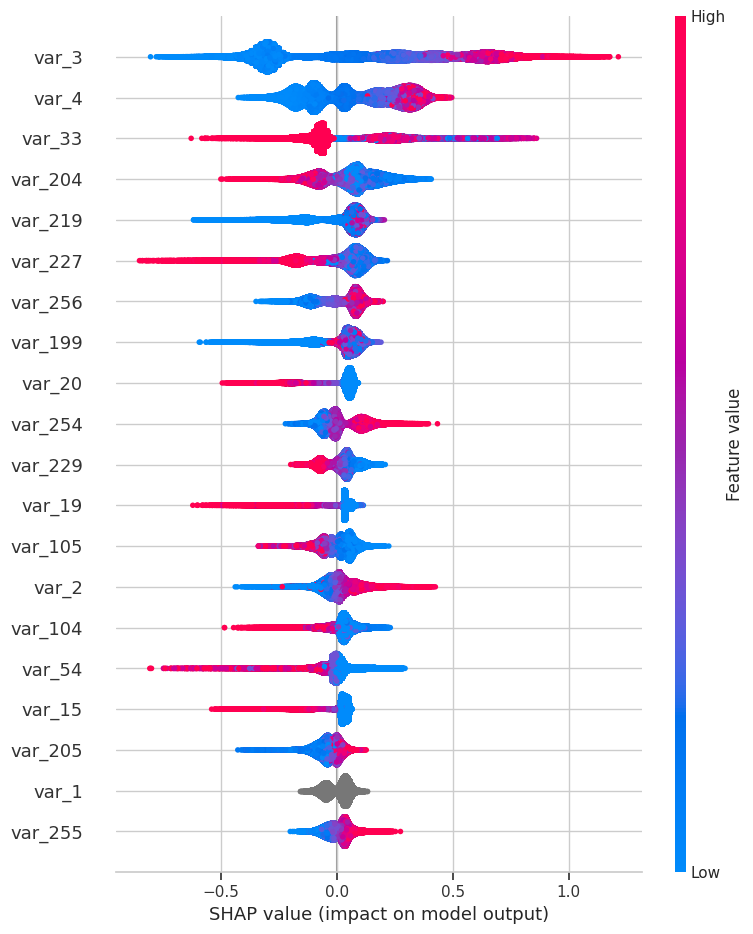

In [ ]:
shap.summary_plot(shap_values, X_treino)

Features more importantes


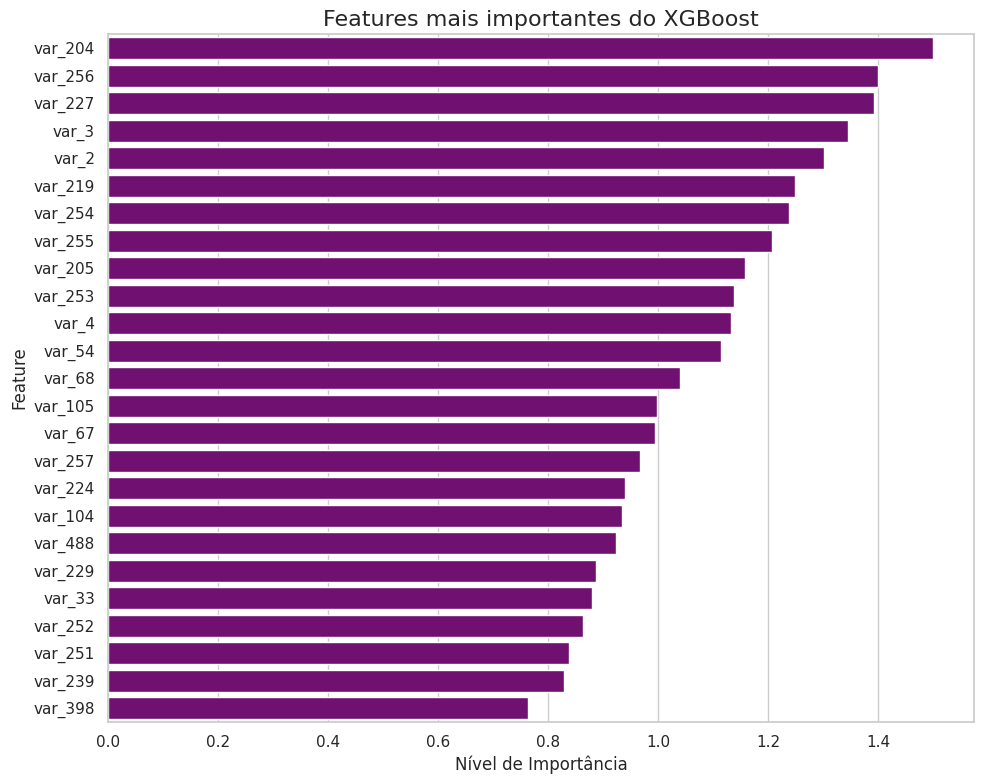

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

booster = class_xgb.get_booster()

# As importâncias das features podem ser obtidas com o método get_score()
# Isso retorna um dicionário {feature_name: importance_value}
importancia_features = booster.get_score(importance_type='weight')


# Criando um DataFrame com as variáveis e suas importâncias
importance_df = pd.DataFrame(importancia_features.items(), columns=['Feature', 'Importance'])
importance_df['Importancia_Normalizada'] =importance_df['Importance']/(sum(importance_df['Importance']))*100
importance_df = importance_df.sort_values(by='Importancia_Normalizada', ascending=False).head(25)

# Configurar o tamanho e estilo do gráfico
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Criar o gráfico de barras horizontal
sns.barplot(x='Importancia_Normalizada', y='Feature', data=importance_df, color = 'purple')
            #palette='viridis')

# Adicionar título e rótulos
plt.title('Features mais importantes do XGBoost', fontsize=16)
plt.xlabel('Nível de Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Mostrar o gráfico
plt.tight_layout()
plt.show()